In [180]:
# Import Libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [158]:
# Read CSV files containing sales transactions and temperatures
pathfile = './datasets/'
data_years = ['2018', '2019', '2020', '2021']


# Load datasets with sales between 2014 and 2019
filename = 'y_'
df_sales = pd.read_csv(pathfile + filename + '2017.csv', infer_datetime_format = True, encoding = 'latin-1')
print('Initiall Shape df_sales: {}'.format(df_sales.shape) )

for year in data_years:
    df_tmp = pd.read_csv(pathfile + filename + year + '.csv', infer_datetime_format = True, encoding = 'latin-1')
    df_sales = pd.concat([df_sales, df_tmp], ignore_index=True)
    print('Shapes df_tmp: {}, df_sales: {}, year: {}'.format(df_tmp.shape, df_sales.shape, year) )

# Read dataset with Minimum Phoenix Temperatures
df_min_temp = pd.read_csv(pathfile + 'phx_min_temp.csv', infer_datetime_format = True,encoding = 'latin-1')

# Read dataset with Maximum Phoenix Temperatures
df_max_temp = pd.read_csv(pathfile + 'phx_max_temp.csv', infer_datetime_format = True,encoding = 'latin-1')

df_tmp = None

Initiall Shape df_sales: (25030, 11)
Shapes df_tmp: (27331, 11), df_sales: (52361, 11), year: 2018
Shapes df_tmp: (27993, 11), df_sales: (80354, 11), year: 2019
Shapes df_tmp: (26658, 11), df_sales: (107012, 11), year: 2020
Shapes df_tmp: (9495, 11), df_sales: (116507, 11), year: 2021


In [159]:
df_sales.head()

,Unnamed: 0,Type,Date,Num,Memo,Name,Item,Qty,Sales Price,Amount,Balance
0,Inventory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00-Beer & Spirits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"00177USA - R2 Casino Azul Blanc (Casino Azul, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Invoice,01/18/2017,70229,"Casino Azul, Tequila Blanco",Total Wine 1006,00-Beer & Spirits:00177USA - R2 Casino Azul Bl...,6.0,29.95,179.7,179.7
4,NaN,Invoice,01/18/2017,70233,"Casino Azul, Tequila Blanco",Total Wine 1004,00-Beer & Spirits:00177USA - R2 Casino Azul Bl...,6.0,29.95,179.7,359.4


In [160]:
def clean_sales(df_sales, target_items):
    '''
    This function is intended to perform cleaning, formating and filtering operations to sales transaction datasets.
    Parameters:
    'df_sales' : (Pandas DataFrame) Dataset contains sales transactions
    'target_items': (Dictionary) Contains the items of interest for the analysis    
    '''
    df = df_sales.copy()
    # Rename Columns
    column_names = ['del1',
                'type',
                'date',
                'inv_num',
                'item_name',
                'customer',
                'item_description',
                'quantity',
                'price',
                'amount',
                'del2'
               ]
    df.columns = column_names
    
    df.drop(['del1','del2'], axis = 1, inplace = True) # drop unuseful columns 
    df.dropna(axis = 0, thresh=5, inplace = True) # Drop rows with NaN values
    
    # Filter all transaction different than Samples
    df = df[~df['customer'].str.lower().str.contains('sample')]
    
    # Extract item_code from item_description
    df['item_code'] = df['item_description'].str.split(expand=True)[0]
    df.drop(['item_description',
             'type',
             'inv_num',
             'customer',
             'amount',
             'item_name'
            ], axis = 1, inplace = True) # Drop columns no interesting for the Analysis
    df = df[df['item_code'].isin(target_items)] # Filter interesting items for Analysis
    
    df['date'] = pd.to_datetime(df['date'], format= '%m/%d/%Y')
    df['month'] = df.date.dt.month # Create a column for months
    df['year'] = df.date.dt.year # Create a column for year
    df.drop('date', inplace = True, axis=1) # Drop column date   
    
    print('Final Dataset Shape: {}'.format(df.shape))
    
    # Assign float32 type for numeric features
    df.quantity = df.quantity.astype(np.float32)
    df.price = df.price.astype(np.float32)
    
    return df

In [161]:
# Dictionary with interest Products for the project
target_items = {'60190':'Dipinti, Pinot Grigio La Vis',
                '70270':'Le Contesse, Prosecchino Brut, 187ml',
                '20209':'Alverdi, Pinot Grigio',
                '70165':'Santome, Prosecco Extra Dry',
                '50215':'Carpineto, Dogajolo Rosso',
                '70208':'Italo Cescon, Pinot Grigio',
                '70271':'Le Contesse, Pinot Noir Rose Brut'
               }
df_sales = clean_sales(df_sales, list(target_items.keys()))

Final Dataset Shape: (9214, 5)


In [162]:

df_sales.head()

,quantity,price,item_code,month,year
5623,7.0,6.99,20209,1,2017
5624,12.0,6.99,20209,1,2017
5625,12.0,6.99,20209,1,2017
5626,12.0,6.99,20209,1,2017
5627,6.0,6.99,20209,1,2017


In [163]:
x = df_sales.groupby(by=['item_code','year','month'], as_index=False).agg(
    quantity=('quantity','sum'), 
    avg_price=('price', np.mean)
)
x['day'] = "01"
# x.to_excel('sales.xlsx')
x.head(20)


,item_code,year,month,quantity,avg_price,day
0,20209,2017,1,109.0,6.990000,01
1,20209,2017,2,136.0,7.144666,01
2,20209,2017,3,129.0,6.990000,01
3,20209,2017,4,190.0,6.990000,01
4,20209,2017,5,172.0,6.990000,01
5,20209,2017,6,103.0,6.990000,01
6,20209,2017,7,111.0,6.116250,01
7,20209,2017,8,246.0,6.990000,01
8,20209,2017,9,145.0,6.990000,01
9,20209,2017,10,186.0,6.990000,01


In [164]:
x['date'] = pd.to_datetime(x[['year','month','day']])
x.head()

,item_code,year,month,quantity,avg_price,day,date
0,20209,2017,1,109.0,6.990000,01,2017-01-01
1,20209,2017,2,136.0,7.144666,01,2017-02-01
2,20209,2017,3,129.0,6.990000,01,2017-03-01
3,20209,2017,4,190.0,6.990000,01,2017-04-01
4,20209,2017,5,172.0,6.990000,01,2017-05-01


1.B Visualization by Product

Text(0, 0.5, 'Sold Btls')

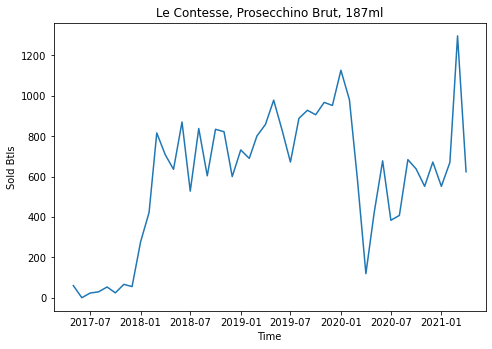

In [195]:
# target_items = {'60190':'Dipinti, Pinot Grigio La Vis',
#                 '70270':'Le Contesse, Prosecchino Brut, 187ml',
#                 '20209':'Alverdi, Pinot Grigio',
#                 '70165':'Santome, Prosecco Extra Dry',
#                 '50215':'Carpineto, Dogajolo Rosso',
#                 '70208':'Italo Cescon, Pinot Grigio',
#                 '70271':'Le Contesse, Pinot Noir Rose Brut'
#                }
item = '70270'
item_set = x[x['item_code']==item]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.plot(item_set['date'], item_set['quantity'])
ax.set_title(str(target_items[item]))
ax.set_xlabel('Time')
ax.set_ylabel('Sold Btls')
# plt.show()

In [191]:
target_items[item]

'Le Contesse, Prosecchino Brut, 187ml'

In [ ]:
# df_sales.set_index('date', inplace=True) # Set 'date' as index

In [70]:

alverdi = df_sales[df_sales['item_code']=='20209']
print(alverdi.shape)

(1920, 4)


In [71]:
alverdi.head()

,item_name,quantity,price,item_code
date,,,,
2017-01-04,"Alverdi, Pinot Grigio 2015",7.0,6.99,20209
2017-01-04,"Alverdi, Pinot Grigio 2015",12.0,6.99,20209
2017-01-13,"Alverdi, Pinot Grigio 2015",12.0,6.99,20209
2017-01-18,"Alverdi, Pinot Grigio 2015",12.0,6.99,20209
2017-01-20,"Alverdi, Pinot Grigio 2015",6.0,6.99,20209


In [67]:
x = alverdi.groupby('item_code')
print(len(x))
x.head()


1


,item_name,quantity,price,item_code
date,,,,
2017-01-04,"Alverdi, Pinot Grigio 2015",7.0,6.99,20209
2017-01-04,"Alverdi, Pinot Grigio 2015",12.0,6.99,20209
2017-01-13,"Alverdi, Pinot Grigio 2015",12.0,6.99,20209
2017-01-18,"Alverdi, Pinot Grigio 2015",12.0,6.99,20209
2017-01-20,"Alverdi, Pinot Grigio 2015",6.0,6.99,20209


In [74]:
alverdi.groupby([pd.Grouper(freq='M'), 'quantity']).sum()

item_name  \
date       quantity                                                      
2017-01-31 6.0                              Alverdi, Pinot Grigio 2015   
           7.0                              Alverdi, Pinot Grigio 2015   
           12.0      Alverdi, Pinot Grigio 2015Alverdi, Pinot Grigi...   
2017-02-28 3.0       Alverdi, Pinot Grigio 2015Alverdi, Pinot Grigi...   
           4.0                              Alverdi, Pinot Grigio 2015   
...                                                                ...   
2021-03-31 48.0                            Alverdi, Pinot Grigio, 2019   
2021-04-30 6.0                             Alverdi, Pinot Grigio, 2019   
           12.0      Alverdi, Pinot Grigio, 2019Alverdi, Pinot Grig...   
           24.0      Alverdi, Pinot Grigio, 2019Alverdi, Pinot Grig...   
           36.0                            Alverdi, Pinot Grigio, 2019   

                                                price  \
date       quantity                                     
2017-01-31 6.0                                   6.99   
           7.0                                   6.99   
           12.0      6.996.996.996.996.996.996.996.99   
2017-02-28 3.0                           8.156.998.15   
           4.0                                   6.99   
...                                               ...   
2021-03-31 48.0                                  6.99   
2021-04-30 6.0                                   7.49   
           12.0                                156.28   
           24.0                                 14.48   
           36.0                                  6.99   

                                                             item_code  
date       quantity                                                     
2017-01-31 6.0                                                   20209  
           7.0                                                   20209  
           12.0               2020920209202092020920209202092020920209  
2017-02-28 3.0                                         202092020920209  
           4.0                                                   20209  
...                                                                ...  
2021-03-31 48.0                                                  20209  
2021-04-30 6.0                                                   20209  
           12.0      2020920209202092020920209202092020920209202092...  
           24.0                                             2020920209  
           36.0                                                  20209  

[245 rows x 3 columns]

In [69]:
x =  x['item_code'].resample('M', how=[np.sum, len])
x.head()

AttributeError: 'DatetimeIndexResamplerGroupby' object has no attribute 'head'

In [57]:
x = df_sales.groupby(by= df_sales.index.month).agg({'quantity':'sum','item_code':'min'})

x = x[x['item_code']=='20209']

x.head(20)
# target_items = ['60190','70270','20209','70165','50215','70208','70271']

,quantity,item_code
date,,
1,11985.0,20209
2,12803.0,20209
3,15671.0,20209
4,10648.0,20209
5,9553.0,20209
6,9005.0,20209
7,6816.0,20209
8,9697.0,20209
9,9502.0,20209


In [12]:
df_sales.head()

,date,item_name,quantity,price,item_code
5623,2017-01-04,"Alverdi, Pinot Grigio 2015",7.0,6.99,20209
5624,2017-01-04,"Alverdi, Pinot Grigio 2015",12.0,6.99,20209
5625,2017-01-13,"Alverdi, Pinot Grigio 2015",12.0,6.99,20209
5626,2017-01-18,"Alverdi, Pinot Grigio 2015",12.0,6.99,20209
5627,2017-01-20,"Alverdi, Pinot Grigio 2015",6.0,6.99,20209


In [13]:
# Apply Date filter to select only the time period of interest
# df_sales_2021[(df_sales_2021['date']>'2020/01/01') & (df_sales_2021['date']<'2020/06/01')]

In [329]:
print(df.shape)
# df.query('item_code == "60190"').count()

(3666, 9)


In [14]:

#     df.set_index('date', inplace=True) # Set 'date' as index
#     df = df.loc[start_date:end_date] # filter data points by dates
#     print('shape after index: {}'.format(df.shape))
df_sales.to_excel('sales.xlsx')

In [317]:
df_sales_2021.groupby(['item_code'], as_index=False).agg({'quantity':'sum','item_name':'max'})
# target_items = ['60190','70270','20209','70165','50215','70208','70271']

,item_code,quantity,item_name
0,20209,7109.0,"Alverdi, Pinot Grigio, 2019"
1,50215,5313.0,"Poderi Einaudi Barolo ""Costa Grimaldi"" 2012"
2,60190,6958.0,"Dipinti, Pinot Grigio, La Vis 2018 (Mich)"
3,70165,6240.0,"Zabu, Nero d' Avola, 2018"
4,70208,5916.0,"Marcarini, Barolo ""La Serra"" 2015"
5,70270,10368.0,"Le Contesse, Prosecchino Brut, 187ml"
6,70271,4208.0,"Le Contesse, Pinot Noir Rose Brut, NV (mich)"
